In chapter 3 of the Deep Learning book, Goodwin defines the Kullback-Leibler (KL) divergence between two probability distributions P and Q. And although the KL divergence is often used as measuring the "distance" between distributions, it is actually not a metric because it is asymmetric.

The plot on page 91 gives a nice indication of how the asymmetry affects minimizing the KL divergence. The example considers a 1-dimensional Gaussian mixture P and finding a single Gaussian that minimizes KL divergence. This simple problem shows the different notions of choosing KL p||q or KL q||p.

Here is how to re-create the plots within Python using numpy and matplotlib.

First, we need to get the imports right.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

Next, we define the relevant low-level functions. While normally one would expect that machine learning libraries have these as built-ins, we will simply hard code them for ourselves - not worrying about numerical stability, etc.

Let's start with a vectorized version of the KL divergence.

In [44]:
def kullback_leibler(p_x, p_y):
    """
    compute the kullback-leibler divergence of two discrete probability distributions declared by the arrays p_x, p_y
    :param p_x:
    :param p_y:
    :return:
    """
    return np.array(p_x).dot(np.log(np.array(p_x)) - np.log(np.array(p_y)))

The well-known Gaussian density formula - quick and dirty :)

In [45]:
def gaussian_density(mu, sigma, xs):
    """
    1-dimensional gaussian distribution
    :param mu:
    :param sigma:
    :param xs:
    :return:
    """
    return (1 / (np.sqrt(2*np.pi*sigma))) * np.exp(- ((xs - mu)**2) / (2*sigma))

Now, we also need a helper function to get simple mixtures of two Gaussians. That's our factory of the P probability function.

In [46]:
def function_p(xs, mus, sigmas, weight):
    """
    Mixture of two 1-dimensional gaussians
    :param xs:
    :param mus:
    :param sigmas:
    :param weight:
    :return:
    """
    gauss_A = gaussian_density(mus[0], sigmas[0], xs)
    gauss_B = gaussian_density(mus[1], sigmas[1], xs)
    gauss_C = weight * gauss_A + (1-weight) * gauss_B

    return gauss_C

Next, we define the x-range that we want to use for our functions, plus the parameters of P, which are just two means and sigmas. Note that the first mean (0) and the second one (8) have to be sufficiently separated, otherwise the asymmetric effect is not as noticeable in the plots later on. Also we have the same variance for both Gaussians of the mixture.

In [47]:
xs = np.arange(-3, 11, 0.01)
mus = [0, 8]
sigmas = [1, 1]

Now it's time to tackle the minimzation problem. Actually, we have two, as mentioned before KL p||q and KL q||p. Here, we simply search through a combination of means and sigmas over a limited range and take the parameter arguments that yield minimum values for KL.

In [48]:
min_p_q = np.inf
min_mu_sigma_p_q = ()
min_q_p = np.inf
min_mu_sigma_q_p = ()

# brute-force search for minimum KL-divergence
for mu in np.arange(min(mus), max(mus), 0.1):
    for sigma in np.arange(1, max(mus) - min(mus) + 1, 0.1):
        ps = function_p(xs, mus, sigmas, 0.5)
        qs = gaussian_density(mu, sigma, xs)
        value_p_q = kullback_leibler(ps, qs)
        if value_p_q < min_p_q:
            min_p_q = value_p_q
            min_mu_sigma_p_q = (mu, sigma)
        value_q_p = kullback_leibler(qs, ps)
        if value_q_p < min_q_p:
            min_q_p = value_q_p
            min_mu_sigma_q_p = (mu, sigma)
            
print "KL p||q: ", min_p_q
print "argmin mu: %f , sigma: %f" %(min_mu_sigma_p_q[0], min_mu_sigma_p_q[1])

print "KL q||p: ", min_q_p
print "argmin mu: %f , sigma: %f" %(min_mu_sigma_q_p[0], min_mu_sigma_q_p[1])

KL p||q:  85.7783155498
argmin mu: 4.000000 , sigma: 8.900000
KL q||p:  69.2133250287
argmin mu: 0.000000 , sigma: 1.000000


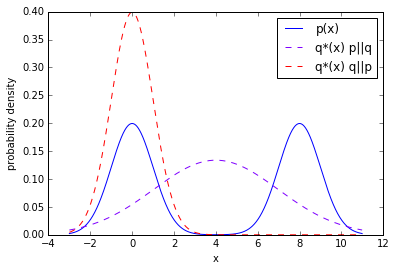

In [49]:
# plot the 3 distributions
colors = cm.rainbow(np.linspace(0, 1, 2))
plt.figure()
ax = plt.plot(xs, function_p(xs, mus, sigmas, 0.5), label='p(x)')
plt.draw()

ax2 = plt.plot(xs, gaussian_density(min_mu_sigma_p_q[0], min_mu_sigma_p_q[1], xs), color=colors[0],
               linestyle='dashed', label='q*(x) p||q')
plt.draw()
ax3 = plt.plot(xs, gaussian_density(min_mu_sigma_q_p[0], min_mu_sigma_q_p[1], xs), color=colors[1],
               linestyle='dashed', label='q*(x) q||p')
plt.draw()
plt.xlabel('x')
plt.ylabel('probability density')
plt.legend()
plt.show()

And voila - we have the figure.

The distribution for Q in KL p||q is chosen w.r.t to the first mode of the mixture P, as it tries to have low probability where P has low probability and thereore aligns to one of the modes of P.

For Q in KL q||p, it tries to have high probability where P has high probability and therefore blurs between the two modes - exactly in the middle, stretching variance as wide as possible.

You can play with the parameters and see the effects on the chosen Q.